# CS105 Survey
Members: John Huh, Emily Mai, Calvin Ng

# Data Pre-processing

In [4]:
# import necessary libraries
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import itertools
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [2]:
# load the data
def load_data(start=0, end=10000, path="data/yelp_academic_dataset_review.json"):
    datafile = open(path, encoding='utf-8')
    data = []
    for i, line in tqdm(enumerate(datafile)):
        if i in list(range(start, end)):
            data.append(json.loads(line))
        if i > end:
            break
    datafile.close()
    df = pd.DataFrame(data)
    return df

# Text Embedding

In [3]:
# function to embedd the reviews
def load_embeddings(dataframe, column):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    messages = np.asarray(dataframe[column])
    tensor_list = tf.convert_to_tensor(messages)
    embeddings = np.array(embed(tensor_list)).tolist()
    # return the reviews followed by their respective embeddings
    return messages, embeddings

In [4]:
# function to show the embeddings
def show_embeddings(n, reviews, embeddings):
    # print first n review embeddings
    for i, message_embedding in enumerate(embeddings[:n]):
        print("Message: {}".format(reviews[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Batch Processing

In [5]:
# function to process batches of the data
def batch_process(step=10000, stop=50000):
    review_df = pd.DataFrame()
    # generate ranges (i.e. [(0,1000), (1000,2000), ...]
    batches = [(n, min(n + step, stop)) for n in range(0, stop, step)]
    for s, e in batches:
        print("Processing {}:{}...".format(s, e))
        # load data and embeddings
        df = load_data(s, e)
        text, embeddings = load_embeddings(df, "text")
        # store embeddings in dataframe
        df["embedding"] = embeddings
        # add new embeddings to main dataframe
        review_df = pd.concat([review_df, df], ignore_index=True, sort=False)

    # save to pickle file to avoid reprocessing of embeddings
    review_df.to_pickle("data/data.pkl")
    print(review_df)


# batch_process()

# if you have the pkl file just run this:
# review_df = pd.read_pickle("data/data.pkl")
# review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,embedding
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,"[-0.018010487779974937, -0.050318099558353424,..."
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,"[-0.04308006912469864, -0.019955946132540703, ..."
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,"[-0.01958566904067993, -0.04187788814306259, -..."
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,"[-0.044252898544073105, -0.07447142153978348, ..."
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,"[0.013128811493515968, -0.01807524263858795, 0..."


# Reviews Clustering

In [55]:
# clustering using Gaussian Mixture Models
# grid search hyper-parameters and return best model and scores
def gmm_model_selection(n_clusters, X):
    lowest_bic = np.infty
    bic = []
    assert X.shape[0] >= n_clusters
#     cv_types = ['spherical', 'tied', 'diag', 'full']
#     for cv_type in cv_types:
    cv_type = 'diag'
    for k in range(1, n_clusters):
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    print("Num components chosen by GMM: {}".format(best_gmm.n_components))
    return best_gmm, bic

# clustering using DBSCAN
# grid search hyper-parameters and return best model and scores
def dbscan_model_selection(X):
    lowest_ss = np.infty
    scores = []
    for epsilon in [.95, 1]:
        for min_samples in [3, 5, 7, 9]:
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
            labels = db.labels_
            scores.append(metrics.silhouette_score(X, labels))
            if scores[-1] < lowest_ss:
                lowest_ss = scores[-1]
                best_db = db
    labels = best_db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(lowest_ss, n_clusters_, n_noise_)
    return best_db, scores

# visualization for clusters
def plot_tsne(gmm, X, Y):
    # dimensionality reduction
    x_reduced = TSNE(n_components=2).fit_transform(X)

    # plot points and their respective colors according to cluster
    color_iter = itertools.cycle(['blue', 'grey', 'darkorange', 'green'])
    for i, (mean, color) in enumerate(zip(gmm.means_, color_iter)):
        if not np.any(Y == i):
            continue
        plt.scatter(x_reduced[Y == i, 0], x_reduced[Y == i, 1], 5, color=color)

    plt.xticks(())
    plt.yticks(())
    plt.title(f'Selected GMM: {gmm.covariance_type} model, 'f'{gmm.n_components} components')
    plt.show()

Num components chosen by GMM: 3


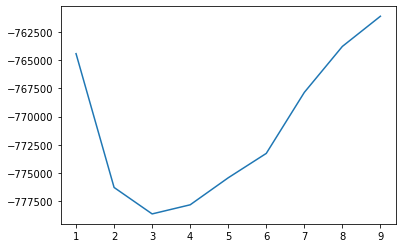

In [56]:
# load data for one business
data = pd.read_pickle("data/data.pkl")
data = data[data["business_id"] == "bZiIIUcpgxh8mpKMDhdqbA"]
X = np.array(data["embedding"].tolist())

# run once to get best model
best_gmm, bic = gmm_model_selection(10, X)
plt.plot(np.arange(1,10), bic)

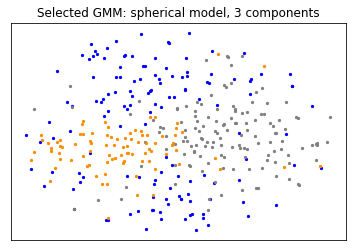

In [60]:
# fit and predict GMM on data
best_gmm = GaussianMixture(n_components=3, covariance_type='spherical').fit(X)

# Y contains generated cluster labels
Y = best_gmm.predict(X)

# generate plot using TSNE
plot_tsne(best_gmm, X, Y)

# Anomaly Detection